In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy.signal import stft, istft , wiener
import soundfile as sf
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import OrthogonalMatchingPursuit, Lasso
from sklearn.decomposition import SparseCoder, DictionaryLearning

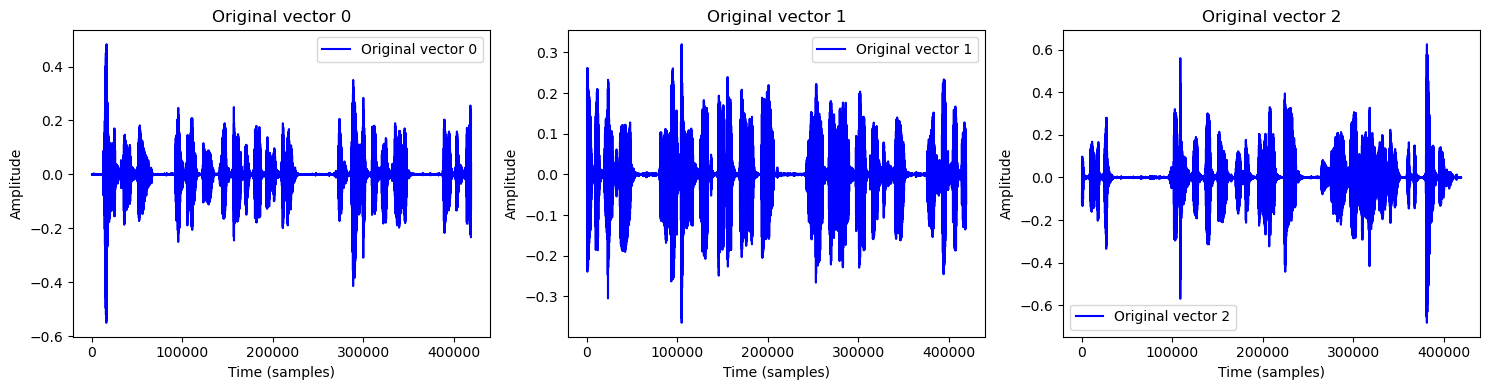

In [2]:
# 1. Load File
audio_path = '../russian37.mp3'
audio, sr = librosa.load(audio_path,sr = None)# sr:The original sample rate of the audio file
segments = np.array_split(audio, 3)  # Split audio into 3 parts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns
for i, (ax, segment) in enumerate(zip(axes, segments)):
    ax.plot(segment, label=f"Original vector {i}", color='b')
    ax.set_title(f"Original vector {i}")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.legend()
plt.tight_layout()
plt.show()

In [14]:
def lasso(y,sr, use_random_dict=False):
    # 2. Signal pre-processing：STFT (Short-Time Fourier Transform)
    f, t, Zxx = stft(y, fs=sr, nperseg=512) # nperseg: length of each segment
    Zxx_real = np.real(Zxx)  # Use only real part for simplicity

    alpha = 0.01
    transform_alpha = alpha

    # 3: Initialize sensing matrices
    n_atoms = 100  # Number of atoms
    if not use_random_dict:
        dict_learner = DictionaryLearning(n_components=n_atoms, random_state=7701, alpha=0.1, fit_algorithm="cd", transform_algorithm="lasso_cd", transform_alpha=0.1)
        dictionary = dict_learner.fit(Zxx_real.T).components_.T  # Train dictionary and get learned components
    else:
        dictionary = np.random.randn(Zxx_real.shape[0], n_atoms) #generates samples from the standard normal distribution (mean = 0, variance = 1)

    #coder_cd = SparseCoder(dictionary=dictionary, transform_alpha=transform_alpha,transform_algorithm="lasso_lars")
    lasso = Lasso(alpha=alpha)
    sparse_coeffs = np.zeros((n_atoms, Zxx_real.shape[1]))

    for i in range(Zxx_real.shape[1]):  # Process each frame(each line in Zxx_real) separately
        lasso.fit(dictionary, Zxx_real[:, i])
        sparse_coeffs[:, i] = lasso.coef_

    # 5: Reconstruct Signal from Sparse Representation
    Zxx_reconstructed = dictionary @ sparse_coeffs
    _, y_reconstructed = istft(Zxx_reconstructed + 1j*np.imag(Zxx), fs=sr, nperseg=512)
    # y_reconstructed = wiener(y_reconstructed) #Apply Wiener Filtering
    return y_reconstructed


segment_reconstructed = []
for i, segment in enumerate(segments):
    reconstructed = lasso(segment, sr, True)
    segment_reconstructed.append(reconstructed)

In [ ]:
# 6: Compute Evaluation Metrics
def compute_metrics(original, reconstructed):
    min_len = min(len(original), len(reconstructed))
    original = original[:min_len]
    reconstructed = reconstructed[:min_len]# Ensure both signals are the same length

    noise = original - reconstructed
    snr = 10 * np.log10(np.sum(original**2) / np.sum(noise**2))# Signal-to-Noise Ratio (SNR)

    mse = mean_squared_error(original, reconstructed)# Mean Squared Error (MSE)

    pcc, _ = pearsonr(original, reconstructed)# Pearson Correlation Coefficient (PCC)

    return snr, mse, pcc

snr, mse, pcc = [], [], []
for i, segment in enumerate(segments):
    snr1, mse1, pcc1 = compute_metrics(segment, segment_reconstructed[i])
    snr.append(snr1)
    mse.append(mse1)
    pcc.append(pcc1)

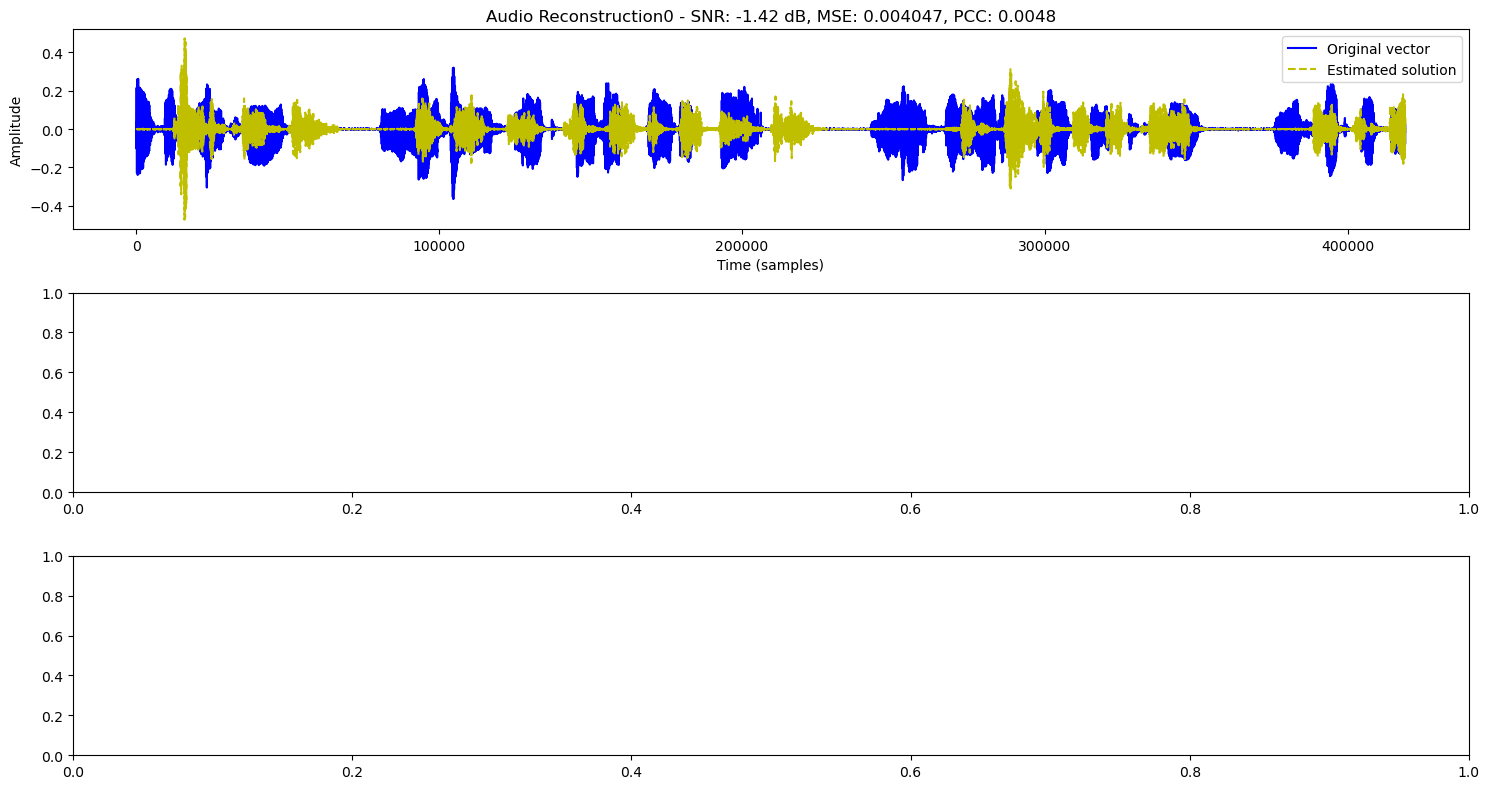

In [ ]:
# 7: Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 8))  # 1 row, 3 columns
for i, (ax, segment) in enumerate(zip(axes, segments)):
    ax.plot(segment, label="Original vector", color='b')
    ax.plot(segment_reconstructed[i], '--', label="Estimated solution", color='y')
    ax.set_title(f"Audio Reconstruction{i} - SNR: {snr[i]:.2f} dB, MSE: {mse[i]:.6f}, PCC: {pcc[i]:.4f}")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.legend()
plt.tight_layout()
plt.show()

In [17]:
# 8: Average metric
snr_avg=np.average(snr)
mse_avg=np.average(mse)
pcc_avg=np.average(pcc)
print(f"Average SNR: {snr_avg:.2f} dB")
print(f"Average MSE: {mse_avg:.6f}")
print(f"Average PCC: {pcc_avg:.4f}")

Average SNR: 3.37 dB
Average MSE: 0.001489
Average PCC: 0.7358
